<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.HousePrices/blob/FeatureAnalysis/House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objectives:
1. Learn important feature selection
- SelectKBest from scikit learn
- Correlation matrix
- Feature importance from classifiers

# Train preparation:
1. Delete certain Nan cols
2. Keep only selected numeric & categorical features


# **0. Packages, constants and Functions**

## Packages

In [465]:
import pandas as pd
import numpy as np
from google.colab import drive

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Printing
import pprint

# Feature selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# Encoding
from sklearn.preprocessing import OrdinalEncoder

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import make_pipeline

# Model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# For my functions
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import mean_squared_log_error

## Constants

In [434]:
train_proportion = 0.8
validation_proportion = 0.2
rand_state = 42

# Feature selection
select_k_numerics = 20  # select 20 out of 36 numeric features
nan_drop_thresh = 0.25

## Functions

In [435]:
def nan_statistics(df, nan_thresh=0.4):
    res = {}
    nan_cols = df.loc[:, df.isnull().any()].columns
    for col in nan_cols:
        res[col] = nan_percentage(df, col)
    print(f'Col -- Nan percentage')
    for key, val in sorted(res.items(), key=lambda item: item[1], reverse=True):
        if val >= nan_thresh * 100:
            print(key, val)
        else:
            del res[key]
    return res

def nan_percentage(df, colname):
    return (df[colname].isnull().sum() / df.shape[0]) * 100

def corr_filter(corr_matrix, target_feature, abs_thresh=0.3):
    res = {}
    series = corr_matrix[target_feature]
    for idx, val in series.items():
        if abs(val) >= abs_thresh:
            res[idx] = val  # Feature names and corr coeff
    return res

def print_unique_dtypes(df):
    print(set(train.dtypes.values))

class FeaturesTransformers:
    def __init__(self, features, transformers):
        self.features = features
        self.transformers = transformers

In [436]:
def build_pipe(model, **transformers):
    res_transformers = []
    for key, val in transformers.items():
        res_transformers.append((key, val.transformers, val.features))

    preprocess = ColumnTransformer(
        res_transformers
    )
    
    pipe = Pipeline(
        steps = [
                 ('preprocessing', preprocess),
                 ('modeling', model)
        ]
    )
    return pipe

def first_tune(models, scoring, X_train, Y_train, transformers):
    res = dict()
    for name, model in models:
        model_pipeline = build_pipe(model, **transformers)
        cv_scores = cross_val_score(model_pipeline, X_train, Y_train, scoring=scoring)
        res[name] = cv_scores

    return dict(sorted(res.items(), reverse=True, key=lambda x: np.mean(x[1])))

## Data download

In [437]:
# Setting file download from google Drive

drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/'
df_path = 'ML/Datasets/2.HousePrices/'

train_path = gdrive_path + df_path + "train.csv"
test_path =  gdrive_path + df_path + "test.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [438]:
train = pd.read_csv(train_path, index_col='Id')
test = pd.read_csv(test_path, index_col='Id')
target = train['SalePrice']

# **1. Feature exploration**

## **1.1. Nan statistics & target dist**

In [439]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


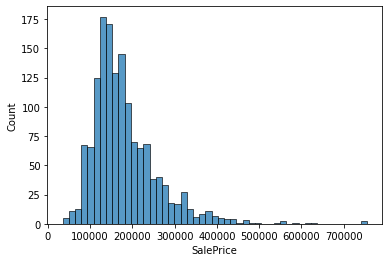

In [440]:
# Check price dist in train
sns.histplot(train['SalePrice'])

In [441]:
res_nan_stat = nan_statistics(train, nan_thresh=nan_drop_thresh)

Col -- Nan percentage
PoolQC 99.52054794520548
MiscFeature 96.30136986301369
Alley 93.76712328767123
Fence 80.75342465753424
FireplaceQu 47.26027397260274


In [442]:
nan_statistics(test, nan_thresh=nan_drop_thresh)

Col -- Nan percentage
PoolQC 99.7943797121316
MiscFeature 96.50445510623715
Alley 92.66620973269363
Fence 80.12337217272105
FireplaceQu 50.03427004797807


{'Alley': 92.66620973269363,
 'Fence': 80.12337217272105,
 'FireplaceQu': 50.03427004797807,
 'MiscFeature': 96.50445510623715,
 'PoolQC': 99.7943797121316}

**Insight #1: Remove features with Nans > 40% (PoolQC, MiscFeature, Alley, Fence, FireplaceQu)**

## **1.2. Select K best numerics**

In [443]:
# Choose numeric types and try SelectKBest features
train_numeric = train.select_dtypes(include=['float64', 'int64'])

train_numeric.drop(columns=['SalePrice'], inplace=True)
train_numeric.fillna(train_numeric.median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [444]:
features_selector = SelectKBest(score_func=chi2, k=select_k_numerics)
fit = features_selector.fit(train_numeric, target)

In [445]:
feature_scores = pd.DataFrame({
    'Scores': pd.Series(fit.scores_),
    'Colnames': pd.Series(train_numeric.columns)
})
feature_scores.nlargest(select_k_numerics, 'Scores')

,Scores,Colnames
2,1.011497e+07,LotArea
33,6.253332e+06,MiscVal
13,4.648841e+05,2ndFlrSF
8,3.999851e+05,BsmtFinSF1
32,3.835642e+05,PoolArea
9,3.688827e+05,BsmtFinSF2
7,2.880241e+05,MasVnrArea
10,2.747512e+05,BsmtUnfSF
14,2.448810e+05,LowQualFinSF
15,1.968501e+05,GrLivArea


**Insight #2. Number of important numeric columns**

## **1.3. Heatmap for numerics**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


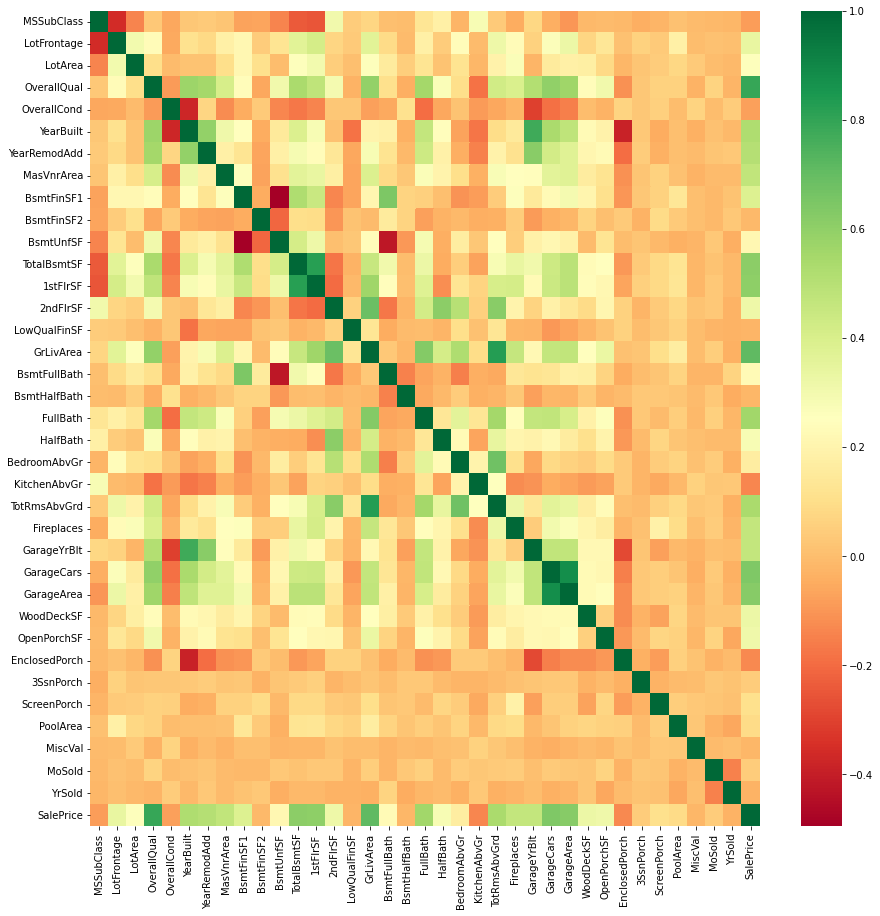

In [446]:
train_numeric['SalePrice'] = target
corr_matrix = train_numeric.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="RdYlGn")

**Insight. There are ~14 numeric features, highly correlated with the target**

In [447]:
num_corr_res = corr_filter(
    corr_matrix,
    target_feature='SalePrice',
    abs_thresh=0.4)
del num_corr_res['SalePrice']

In [448]:
for feature_name, corr_coef in num_corr_res.items():
    print(feature_name, corr_coef)

OverallQual 0.7909816005838047
YearBuilt 0.5228973328794967
YearRemodAdd 0.5071009671113867
MasVnrArea 0.47261449900457725
TotalBsmtSF 0.6135805515591944
1stFlrSF 0.6058521846919166
GrLivArea 0.7086244776126511
FullBath 0.5606637627484452
TotRmsAbvGrd 0.5337231555820238
Fireplaces 0.4669288367515242
GarageYrBlt 0.4667536523633402
GarageCars 0.640409197258349
GarageArea 0.6234314389183598


## **1.4. Select K best categorical**

In [449]:
print_unique_dtypes(train)

{dtype('float64'), dtype('O'), dtype('int64')}


In [450]:
train_categorical = train.select_dtypes(include=['O'])
train_categorical.fillna("Missing", inplace=True)
train_categorical['SalePrice'] = target
train_categorical.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Missing,Attchd,RFn,TA,TA,Y,Missing,Missing,Missing,WD,Normal,208500
2,RL,Pave,Missing,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,Missing,Missing,Missing,WD,Normal,181500
3,RL,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Missing,Missing,Missing,WD,Normal,223500
4,RL,Pave,Missing,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,Missing,Missing,Missing,WD,Abnorml,140000
5,RL,Pave,Missing,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,Missing,Missing,Missing,WD,Normal,250000


In [451]:
encoder = OrdinalEncoder()
encoder.fit(train_categorical)
train_categorical_enc = pd.DataFrame(encoder.transform(train_categorical), columns=train_categorical.columns)

In [452]:
for c1, c2 in zip(train_categorical.columns, train_categorical_enc.columns):
    if len(train_categorical[c1].unique()) != len(train_categorical_enc[c2].unique()):
        print(f'SMTH WRONG!!')

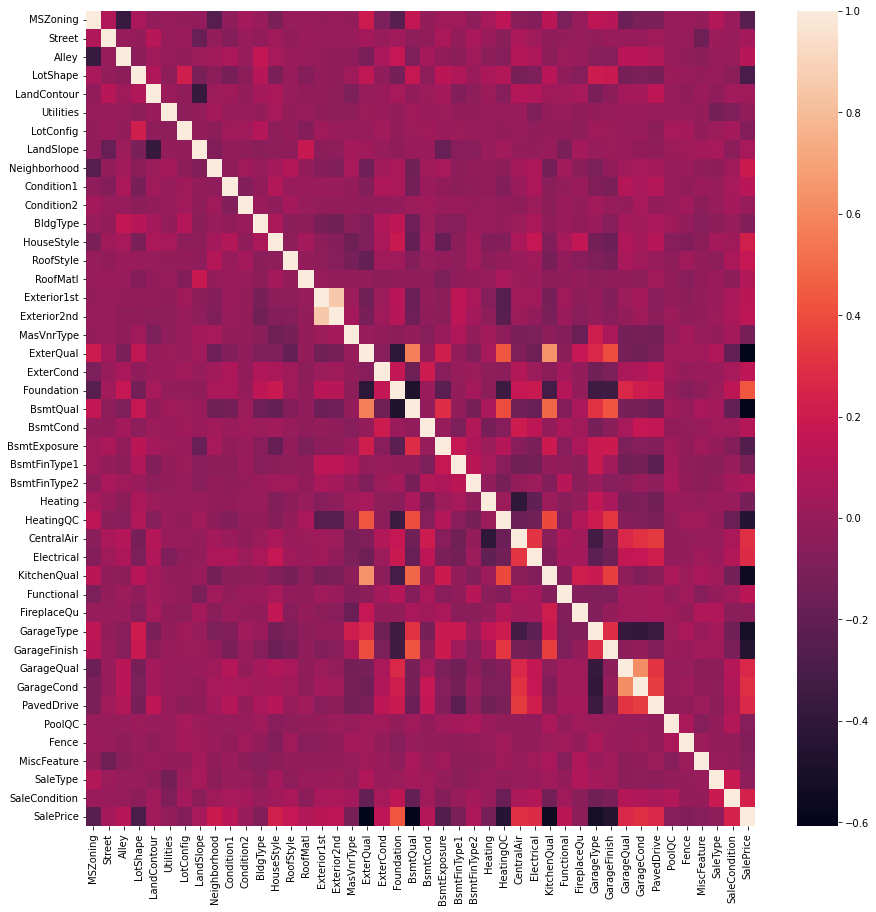

In [453]:
plt.figure(figsize = (15, 15))
sns.heatmap(train_categorical_enc.corr())

In [454]:
cat_corr_res = corr_filter(
    train_categorical_enc.corr(),
    target_feature='SalePrice',
    abs_thresh=0.4)
del cat_corr_res['SalePrice']

In [455]:
for k, v in cat_corr_res.items():
    print(k, v)

ExterQual -0.6077319171777064
Foundation 0.43346029874118397
BsmtQual -0.5995824867371836
HeatingQC -0.4494094145977739
KitchenQual -0.5557030395887256
GarageType -0.5131959673404168
GarageFinish -0.4512968880777271


**Insight. Categorical values, highly (>0.4) correlated with the target**
**(Probably, manually insert ordering -> we will catch more features)**

#**2. Dataset clean (based on insights)**

In [456]:
nan_features = res_nan_stat.keys()

num_features_to_keep = list(num_corr_res.keys())
cat_features_to_keep = list(cat_corr_res.keys())

print(num_features_to_keep)
print(cat_features_to_keep)
print(nan_features)

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea']
['ExterQual', 'Foundation', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish']
dict_keys(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'])


## **2.1. Drop Nan**

In [457]:
def drop_cols(df, cols):
    df.drop(columns = cols, inplace=True)

## **2.2. Keep only relevant features**

In [458]:
def drop_cols_except(df, num_features, cat_features):
    df.drop(df.columns.difference(cat_features + num_features), 1, inplace=True)

## **Final procedure**

In [459]:
# Train
drop_cols(train, nan_features)
drop_cols_except(
    train, 
    num_features_to_keep + ['SalePrice'], 
    cat_features_to_keep
)
train['HeatingQC'] = train['HeatingQC'].astype('category').cat.codes
# -----

# Test
drop_cols(test, nan_features)
drop_cols_except(
    test,
    num_features_to_keep,
    cat_features_to_keep
)
test['HeatingQC'] = test['HeatingQC'].astype('category').cat.codes
# -----

y = train['SalePrice']
train.drop(columns=['SalePrice'], inplace=True)

# **3. Baseline Model**

## **3.1. Define pipelines & transformers for num & cat features**

In [460]:
print(train.dtypes.unique())

num_features = list(train.select_dtypes(include=['int64', 'float64']).columns)
cat_features = list(train.select_dtypes(include=['O']).columns)

print(cat_features)
print(num_features)

[dtype('int64') dtype('float64') dtype('O') dtype('int8')]
['ExterQual', 'Foundation', 'BsmtQual', 'KitchenQual', 'GarageType', 'GarageFinish']
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [462]:
cat_pipeline = Pipeline(
    steps = [
             ('imputer', SimpleImputer(strategy='most_frequent')),
             ('ordinal', OrdinalEncoder())
    ]
)

num_pipeline = Pipeline(
    steps = [
             ('imputer', SimpleImputer()),
             ('scaler', StandardScaler())
    ]
)

cat_transformer = FeaturesTransformers(cat_features, cat_pipeline)
num_transformer = FeaturesTransformers(num_features, num_pipeline)

## **3.2. Approximate tune, try models**

In [466]:
models = [
          ('Regression', LinearRegression()),
          ('RF', RandomForestRegressor())
]

res_dict = first_tune(
    models,
    scoring='neg_mean_squared_log_error',
    X_train=train,
    Y_train=y,
    transformers = dict(
        a=cat_transformer,
        b=num_transformer
    )
)

In [474]:
d_sorted = {k:v.mean() for k, v in sorted(res_dict.items(), key = lambda item: sum(item[1]))}
d_sorted

{'RF': -0.025182957554680724, 'Regression': -0.03257464128554511}